In [1]:
import os
import torch
import torchvision

import statistics
import h5py
import copy
import cv2
import deepdish as dd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from sklearn.metrics import roc_auc_score
from skimage import measure

import sklearn.metrics as metrics
import numpy as np
from sklearn.metrics import roc_curve, auc, jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


import tempfile
import time
import pickle as pkl;

In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/

In [2]:
n_epochs = 50
patience_limit = 20
patience = 0
batch_size_train = 4# was 64
batch_size_test = 4
learning_rate = 0.001
momentum = 0.1
log_interval = 31
tt_factor = 0.8
orientation = 'AP'
num_imgs = 5000

model_path = './data/saved_models/' + 'all_diseases_all_imgs' + '.pth'

random_seed = 1
#torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
dis_small_map = {'Cardiomegaly': 0, 'Effusion': 1, 'Mass': 2, 'Nodule': 3, 'Atelectasis': 4, 'No Finding': 5}

In [4]:
class GetLoader_w_val(torch.utils.data.Dataset):
    '''
        NOTE: I hardcoded this one a bit, basically splits validation set in half and gives it to test set
    
        Params: data - the data dictionary
                view - the orientation you want to look at
                diseases - the diseases you would like to look at
                num_imgs - the number of images of each disease you would like
                factor - the ratio of training and testing data
                typ - 0 for training, 1 for testing
    '''
    def __init__(self, data, view, diseases, num_imgs, factor, typ, transforms=None):
        
        #private data
        self.root = os.path.join('data/sorted_images',)
        self.data = data # dict object
        self.transforms = transforms
        self.len_data = 0
        datalist = []
        
        #Creating the datalist
        for i in range(len(diseases)):                
            
            if len(data[view][diseases[i]]) <= num_imgs: #if the folder has less images than the desired number of images
                if typ == 0:
                    start = 0
                    end = int(len(data[view][diseases[i]])*factor)
                elif typ == 1:
                    start = int(len(data[view][diseases[i]])*factor)
                    end = int(len(data[view][diseases[i]])*factor + len(data[view][diseases[i]])*(1-factor) / 2)
                else:
                    start = int(len(data[view][diseases[i]])*factor + len(data[view][diseases[i]])*(1-factor) / 2)
                    end = -1
            else:
                if typ == 0:
                    start = 0
                    end = int(num_imgs*factor)
                elif typ == 1:
                    start = int(num_imgs*factor)
                    end = int(num_imgs*factor + num_imgs*(1-factor) / 2)
                else:
                    start = int(num_imgs*factor + num_imgs*(1-factor) / 2)
                    end = num_imgs
                    
            #print('dis: ', diseases[i], ', type: ', typ, ', start: ', start, ', end:', end)
            print('disease: ', diseases[i], 'num images used: ', min(len(data[view][diseases[i]]), num_imgs))
            
            #class_weights[disease_map[diseases[i]]] = num_imgs / min(len(data[view][diseases[i]]), num_imgs)
            
            datalist.append(self.data[view][diseases[i]][start:end])
        
        for item in datalist:
            self.len_data += len(item)
        
        
        self.img_paths = []
        self.img_labels = []
        
        for dis in datalist:
            for data in dis:
                #creating the image path
                data['img_path'] = os.path.join(self.root, data['classes'][0], view, data['img_name'])            
                diseases_item = data['classes']

                one_hot = np.zeros(6)
                for d in diseases_item:
                    if d in diseases:
                        hot_index = dis_small_map[d]
                        one_hot[hot_index] = 1

                self.img_paths.append(data['img_path'])
                self.img_labels.append(torch.Tensor(one_hot))


    def __getitem__(self, item):
        
        img_path, img_label = self.img_paths[item], self.img_labels[item]
  
        # TODO: fix this hot fix -> recreate data object with underscore in name
        img_path = img_path.replace('No Finding', 'No_Finding')
        try:
            img = Image.open(img_path).convert('RGB')
        except:
            img_path = img_path.replace('/AP/', '/PA/')
            img = Image.open(img_path).convert('RGB')
            
        self.cur_img_path = img_path

        if self.transforms is not None:
            for t in self.transforms:
                img = t(img)

        return img, img_label
    
    def get_img_path(self):
        return self.cur_img_path

    def __len__(self):
        return self.len_data

In [5]:
pkl_load = open('dataset_bb.pickle', 'rb')
data_bb = pkl.load(pkl_load)
pkl_load.close()
print("data loaded in successfully")

data loaded in successfully


In [7]:
transforms = [torchvision.transforms.ToTensor()] # no longer grayscale conversion
#0 = train, 1 = test
dataset_train = GetLoader_w_val(data_bb, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
                          num_imgs, tt_factor, 0, transforms)
dataset_valid = GetLoader_w_val(data_bb, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
                          num_imgs, tt_factor, 1, transforms)
dataset_test = GetLoader_w_val(data_bb, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
                          num_imgs, tt_factor, 2, transforms)
print(len(dataset_train))
print(len(dataset_valid))
print(len(dataset_test))

disease:  Cardiomegaly num images used:  146
disease:  Effusion num images used:  153
disease:  Mass num images used:  85
disease:  Nodule num images used:  79
disease:  Atelectasis num images used:  180
disease:  No Finding num images used:  0


KeyError: 'classes'

In [28]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_train, shuffle=True, num_workers=1)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size_train, shuffle=True, num_workers=1)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

4117
515
515


In [29]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)

Using cache found in /home/npp002/.cache/torch/hub/pytorch_vision_v0.6.0


In [30]:
model.fc = nn.Sequential(*[
    nn.Linear(in_features=512, out_features=6, bias=True),
    nn.Sigmoid(),
])
model = torch.nn.DataParallel(model)

In [31]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [32]:
network = model
#network = torchvision.models.vgg11(pretrained=False)
#network.fc = nn.Linear(512, 15)
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
print('Trainable params: {}'.format(sum(p.numel() for p in network.parameters() if p.requires_grad)))

Trainable params: 11179590


In [8]:
class ResNet(nn.Module):
    def __init__(self, model_file):
        super(ResNet, self).__init__()
        
        self.model_file = model_file
        
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
        self.model.fc = nn.Sequential(*[
            nn.Linear(in_features=512, out_features=6, bias=True),
            nn.Sigmoid()
        ])
        
        self.features_conv = nn.Sequential(*list(self.model.children())[:-2])
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier =  nn.Sequential(*list(self.model.children())[-2:][1:])
        
        self.gradients = None
        
    def load_weights(self):
        self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(torch.load(self.model_file))
    
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)

        h = x.register_hook(self.activations_hook)

        x = self.global_pool(x)
        x = x.view(1, -1)    
        x = self.classifier(x)
        
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [9]:
gmodel = ResNet(model_path)

Using cache found in /home/npp002/.cache/torch/hub/pytorch_vision_v0.6.0


In [10]:
gmodel.load_weights()

In [108]:
def check_contains(b1, b2):
    lx = b1['low_x'] <= b2['low_x']
    ly = b1['low_y'] <= b2['low_y']
    hx = b1['high_x'] >= b2['high_x']
    hy = b1['high_y'] >= b2['high_y']
    
    return lx and ly and hx and hy


In [117]:
def check_too_big(b):
    w = b['high_x'] - b['low_x']
    h = b['high_y'] - b['low_y']
    
    return w * h > 350000 # roughly if box is larger than 1/3 of the image then get rid of it

In [150]:
def get_bboxes(label_map):
    uniques = np.unique(label_map)
    boxes = {} # stored as x1, x2, y1, y2
    
    #explore_map = copy.deepcopy()
    
    for u in uniques:
        low_x = 9999
        low_y = 9999
        high_x = -1
        high_y = -1
        
        for r in range(len(label_map)):
            for c in range(len(label_map[0])):
                
                cur = label_map[r][c]
                
                if cur == u:
                    low_x = min(low_x, c)
                    low_y = min(low_y, r)
                    high_x = max(high_x, c)
                    high_y = max(high_y, r)
                    
                    #explore_map = 1
                    
        boxes[u] = {'low_x' : low_x, 'low_y' : low_y,
                        'high_x' : high_x, 'high_y' : high_y}
     
    # step 1: remove the boxes that are too big    
    boxes_temp = copy.deepcopy(boxes)
    for k, b in boxes.items():
        if check_too_big(b):
            boxes_temp.pop(k, None)
            
    boxes = boxes_temp
    
    # step 2: remove boxes that are contained in other boxes
    boxes_temp = copy.deepcopy(boxes)

    for k1, b1 in boxes.items():
        for k2, b2 in boxes.items():
            if k1 != k2 and check_contains(b1,b2):
                boxes_temp.pop(k2, None)
                    
    boxes = boxes_temp
    boxes_temp = {}
    
    #step 3: reset the keys on the boxes, for ex:  [5, 7, 11] --> [0, 1, 2]
    idx = 0
    for k in boxes.keys():
        boxes_temp[idx] = boxes[k]
        idx += 1
        
    boxes = boxes_temp
        
    #print('\n boxes delivered: \n', boxes)
    return boxes

In [151]:
def gen_bbox(img_path, model, disease):
    transform = torchvision.transforms.ToTensor()
    img = Image.open(img_path).convert('RGB')
    img = transform(img)
    img.shape
    img = img.unsqueeze(dim=0)
    img = img.cuda();
    
    model.eval()

    pred = model(img)
    pred[0][dis_small_map[disease]].backward()
    
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) 
    activations = model.get_activations(img).detach() 

    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = heatmap.cpu()
    heatmap /= torch.max(heatmap)
    #plt.matshow(heatmap)
    
    img = cv2.imread(img_path)
    heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    
    colormap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = colormap * 0.4 + img
    cv2.imwrite('./map.jpg', superimposed_img)
    
    blobs = heatmap > 120 #* heatmap.mean()
        
    all_labels = measure.label(blobs)

    
    plt.figure()
    plt.imshow(all_labels)
    
    boxdict = get_bboxes(all_labels)
    
    plt_image = cv2.imread('./map.jpg')
    plt_image = cv2.cvtColor(plt_image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots()
    ax.imshow(plt_image)

    for i in range(len(boxdict)):
        x = boxdict[i]['low_x']
        y = boxdict[i]['low_y']
        width = boxdict[i]['high_x'] - x
        height = boxdict[i]['high_y'] - y
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none' )
        ax.add_patch(rect)

In [152]:
def iobb(x, y, width, height, label_map):
    
    single_level = np.array(label_map >= 1, dtype='int')
    plt.imshow(single_level)
    # convert all labels on prediction to same value of '1' for present and '0' for not present
    temp = np.zeros((1024, 1024), dtype='int')
    for yi in range(1024):
        for xi in range(1024):
            x_bool =  xi > x and xi < x + width
            y_bool =  yi > y and yi < y + height
            
            if x_bool and y_bool:
                temp[yi][xi] = 1
                
    #plt.imshow(temp)
    #plt.imshow(single_level)
    return jaccard_score(temp.flatten(), single_level.flatten())

In [153]:
def get_grad_map(data, model, disease):
    img_path = './data/sorted_images/' + data['disease'] + '/' + data['view'] + '/' + data['img_name']

    transform = torchvision.transforms.ToTensor()
    img = Image.open(img_path).convert('RGB')
    img = transform(img)
    img.shape
    img = img.unsqueeze(dim=0)
    img = img.cuda();
    
    model.eval()

    pred = model(img)
    pred[0][dis_small_map[disease]].backward()
    
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) 
    activations = model.get_activations(img).detach() 

    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = heatmap.cpu()
    heatmap /= torch.max(heatmap)
    #plt.matshow(heatmap)
    
    img = cv2.imread(img_path)
    heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    
    colormap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = colormap * 0.4 + img
    cv2.imwrite('./map.jpg', superimposed_img)
    
    blobs = heatmap > 160 #* heatmap.mean()
        
    all_labels = measure.label(blobs)
    
    return all_labels, blobs

In [193]:
def calc_iobb(data, model, disease):
    label_map, _ = get_grad_map(data, model, disease)
    
    boxes = get_bboxes(label_map)
    
    
    single_level = np.array(label_map >= 1, dtype='int')
    # convert all labels on prediction to same value of '1' for present and '0' for not present
    real_box = np.zeros((1024, 1024), dtype='int')
    x = int(data['x'])
    y = int(data['y'])
    width = int(data['width'])
    height = int(data['height'])
    for xi in range(x, x + width):
        for yi in range(y, y + height):
            real_box[yi][xi] = 1

    pred_boxes = np.zeros((1024, 1024), dtype='int')
    for _, b in boxes.items():
        for xi in range(b['low_x'], b['high_x']+1):
            for yi in range(b['low_y'], b['high_y']+1):
                pred_boxes[yi][xi] = 1
                
#     plt.figure()
#     plt.imshow(real_box)
#     plt.figure()
#     plt.imshow(pred_boxes)
    return jaccard_score(real_box.flatten(), pred_boxes.flatten())
    

In [194]:
def compute_bbox_iou(data, model, disease):
    img_path = './data/sorted_images/' + data['disease'] + '/' + data['view'] + '/' + data['img_name']
    
    transform = torchvision.transforms.ToTensor()
    img = Image.open(img_path).convert('RGB')
    img = transform(img)
    img.shape
    img = img.unsqueeze(dim=0)
    img = img.cuda();
    
    model.eval()

    pred = model(img)
    pred[0][dis_small_map[disease]].backward()
    
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) 
    activations = model.get_activations(img).detach() 

    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = heatmap.cpu()
    heatmap /= torch.max(heatmap)
    #plt.matshow(heatmap)
    
    img = cv2.imread(img_path)
    heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    
    colormap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = colormap * 0.4 + img
    cv2.imwrite('./map.jpg', superimposed_img)
    
    blobs = heatmap > 120 #* heatmap.mean()
        
    all_labels = measure.label(blobs)
    
    plt.imshow(all_labels/35, cmap='gray', vmin=0, vmax=35)
    return iobb(data['x'], data['y'], data['width'], data['height'], all_labels)
    
    #plt.figure()
    #plt.imshow(all_labels)

In [195]:
def bbox_main(data, model, disease):
        
    all_labels, blobs = get_grad_map(data, model, disease)
    
    plt.figure()
    plt.imshow(blobs)
    plt.figure()
    plt.imshow(all_labels)
    
    boxdict = get_bboxes(all_labels)
    
    plt_image = cv2.imread('./map.jpg')
    plt_image = cv2.cvtColor(plt_image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots()
    ax.imshow(plt_image)

    print(boxdict.keys())
    
    for i in range(len(boxdict)):
        x = boxdict[i]['low_x']
        y = boxdict[i]['low_y']
        width = boxdict[i]['high_x'] - x
        height = boxdict[i]['high_y'] - y
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none' )
        ax.add_patch(rect)
    rect = patches.Rectangle((data['x'], data['y']), data['width'], data['height'], linewidth=2, edgecolor='blue', facecolor='none' )
    ax.add_patch(rect)
    
    print('IoBB = ', calc_iobb(data, model, disease))

dict_keys([0, 1, 2, 3])
IoBB =  0.07731344697314686


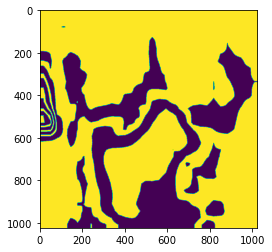

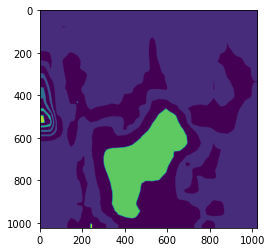

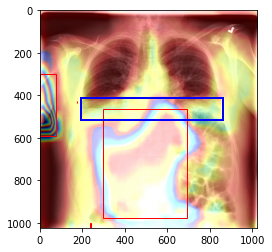

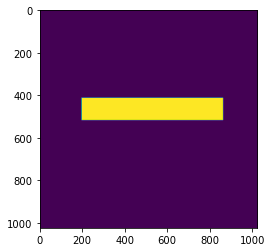

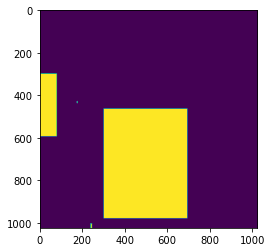

In [196]:
bbox_main(data_bb['AP']['Effusion'][1], gmodel, 'Effusion')

KeyboardInterrupt: 

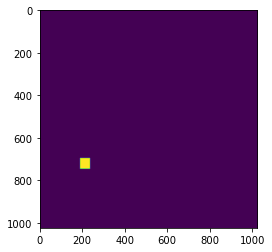

Error in callback <function flush_figures at 0x7f14605f3d40> (for post_execute):


KeyboardInterrupt: 

In [197]:
iobb_vals = [calc_iobb(data_bb['AP']['Effusion'][i], gmodel, 'Effusion') for i in range(0, 100)]
iobb_vals.sort()

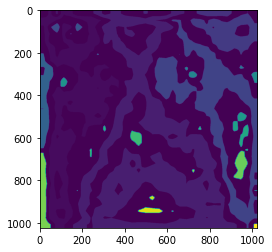

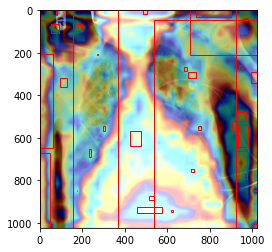

In [24]:
gen_bbox('./data/sorted_images/Cardiomegaly/AP/00005066_030.png', gmodel, 'Cardiomegaly')

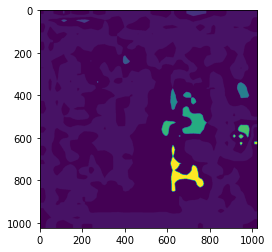

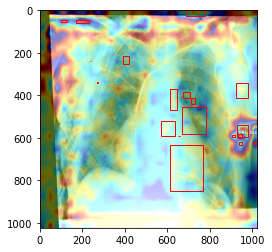

In [19]:
gen_bbox('./data/sorted_images/Mass/AP/00000013_031.png', gmodel, 'Mass')

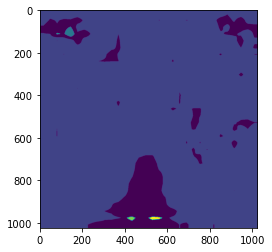

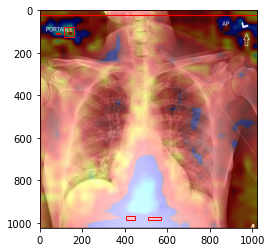

In [20]:
gen_bbox('./data/sorted_images/Atelectasis/AP/00030519_001.png', gmodel, 'Atelectasis')

In [21]:
pkl_load = open('./dataset_bb.pickle', 'rb')
data_bb = pkl.load(pkl_load)
pkl_load.close()
print("dataset for bounding box loaded in successfully")

dataset for bounding box loaded in successfully


In [46]:
bbox_results = {'AP' : {}, 'PA' : {}}

bbox_results['AP'] =  {'Cardiomegaly': [], 'Effusion': [], 'Mass': [], 'Nodule': [], 'Atelectasis': []}
bbox_results['PA'] =  {'Cardiomegaly': [], 'Effusion': [], 'Mass': [], 'Nodule': [], 'Atelectasis': []}

In [56]:
for view in data_bb.keys():
    for disease in bbox_results['AP'].keys():
        for i in range(len(data_bb[view][disease])):
            bbox_results[view][disease].append(compute_bbox_iou(data_bb[view][disease][i], gmodel, disease))
        print(view, disease, 'complete')

AP Cardiomegaly complete
AP Effusion complete
AP Mass complete
AP Nodule complete
AP Atelectasis complete
PA Cardiomegaly complete
PA Effusion complete
PA Mass complete
PA Nodule complete
PA Atelectasis complete


In [48]:
data_bb.keys()

dict_keys(['AP', 'PA'])

In [57]:
for view in bbox_results.keys():
    for disease in bbox_results[view].keys():
        if bbox_results[view][disease]:
            mean = statistics.mean(bbox_results[view][disease])
            bbox_results[view][disease].sort()
            median = bbox_results[view][disease][len(bbox_results[view][disease]) // 2]
        print(view, disease, mean, median)
        print()

AP Cardiomegaly 0.1487217804768757 0.14913752590260934

AP Effusion 0.06917364005319358 0.05750243878191387

AP Mass 0.0336113380663053 0.015747674109975206

AP Nodule 0.00507850780219051 0.0043152350081037275

AP Atelectasis 0.03163882096697622 0.01921908096527521

PA Cardiomegaly 0.1487217804768757 0.14913752590260934

PA Effusion 0.06917364005319358 0.05750243878191387

PA Mass 0.0336113380663053 0.015747674109975206

PA Nodule 0.00507850780219051 0.0043152350081037275

PA Atelectasis 0.03163882096697622 0.01921908096527521



In [ ]:
'''
restructure:
compute iobb and gen bbox could go in the same function together
should all be 1 big thing

main
- generic stuff shared
- print out iobb
- display graph
'''